# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

Setting ds_accelerator to cuda (auto detect)


2023-09-23 19:43:54.850152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 19:43:55.469966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 21
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [7]:
tokenizer = get_tokenizer("basic_english")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

In [9]:
train_dataset = load_dataset("./penn/train.txt")
valid_dataset = load_dataset("./penn/valid.txt")
test_dataset = load_dataset("./penn/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  924412
Valid Tokens:  73339
Test Tokens:  82114
Total number of tokens: 1079865


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 9925


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:
train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class HLSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, (h,c) = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, (h,c) = self.rnn2(output,(c,h))
    output = self.dropout2(output)
    
    output, (h,c) = self.rnn3(output,(c,h))
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 256
hidden_dim = 256
num_layers = 1
dropout_rate = 0.25

model = HLSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 6.670533



H_LSTM(
  (embedding): Embedding(9925, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=9925, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1761/1761 [00:41<00:00, 42.63batch/s, loss=6.11, perplexity=562]   


Valid: Loss = 5.548 Perplexity= 277.0, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1761/1761 [00:39<00:00, 44.34batch/s, loss=5.46, perplexity=254]


Valid: Loss = 5.201 Perplexity= 198.0, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1761/1761 [00:38<00:00, 45.26batch/s, loss=5.13, perplexity=185]


Valid: Loss = 4.866 Perplexity= 141.8, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1761/1761 [00:38<00:00, 45.63batch/s, loss=4.81, perplexity=134]


Valid: Loss = 4.556 Perplexity= 104.2, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1761/1761 [00:38<00:00, 45.20batch/s, loss=4.54, perplexity=102]


Valid: Loss = 4.302 Perplexity= 80.81, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1761/1761 [00:38<00:00, 45.32batch/s, loss=4.28, perplexity=79]  


Valid: Loss = 4.055 Perplexity= 63.23, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1761/1761 [00:38<00:00, 45.41batch/s, loss=4.05, perplexity=62.6]


Valid: Loss = 3.855 Perplexity= 51.64, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1761/1761 [00:38<00:00, 45.42batch/s, loss=3.86, perplexity=51.4]


Valid: Loss = 3.673 Perplexity= 42.92, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1761/1761 [00:38<00:00, 45.45batch/s, loss=3.7, perplexity=43.8] 


Valid: Loss = 3.523 Perplexity= 36.9, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1761/1761 [00:38<00:00, 45.60batch/s, loss=3.56, perplexity=37.9]


Valid: Loss = 3.39 Perplexity= 32.23, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1761/1761 [00:38<00:00, 45.31batch/s, loss=3.43, perplexity=33.3]


Valid: Loss = 3.267 Perplexity= 28.51, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1761/1761 [00:38<00:00, 45.33batch/s, loss=3.31, perplexity=29.5]


Valid: Loss = 3.17 Perplexity= 25.84, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1761/1761 [00:38<00:00, 45.24batch/s, loss=3.21, perplexity=26.5]


Valid: Loss = 3.021 Perplexity= 22.23, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1761/1761 [00:38<00:00, 45.28batch/s, loss=3.1, perplexity=23.9] 


Valid: Loss = 2.951 Perplexity= 20.68, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1761/1761 [00:38<00:00, 45.46batch/s, loss=3.01, perplexity=21.8]


Valid: Loss = 2.826 Perplexity= 18.17, LR = 0.5
Model Saved!



Epoch 15: 100%|██████████| 1761/1761 [00:38<00:00, 45.52batch/s, loss=2.92, perplexity=19.9]


Valid: Loss = 2.757 Perplexity= 16.99, LR = 0.5
Model Saved!



Epoch 16: 100%|██████████| 1761/1761 [00:38<00:00, 45.27batch/s, loss=2.84, perplexity=18.2]


Valid: Loss = 2.708 Perplexity= 16.13, LR = 0.5
Model Saved!



Epoch 17: 100%|██████████| 1761/1761 [00:38<00:00, 45.33batch/s, loss=2.75, perplexity=16.7]


Valid: Loss = 2.592 Perplexity= 14.33, LR = 0.5
Model Saved!



Epoch 18: 100%|██████████| 1761/1761 [00:38<00:00, 45.42batch/s, loss=2.68, perplexity=15.4]


Valid: Loss = 2.539 Perplexity= 13.59, LR = 0.5
Model Saved!



Epoch 19: 100%|██████████| 1761/1761 [00:38<00:00, 45.62batch/s, loss=2.6, perplexity=14.3] 


Valid: Loss = 2.487 Perplexity= 12.87, LR = 0.5
Model Saved!



Epoch 20: 100%|██████████| 1761/1761 [00:38<00:00, 45.70batch/s, loss=2.53, perplexity=13.3]


Valid: Loss = 2.392 Perplexity= 11.68, LR = 0.5
Model Saved!



Epoch 21: 100%|██████████| 1761/1761 [00:38<00:00, 45.68batch/s, loss=2.46, perplexity=12.4]


Valid: Loss = 2.354 Perplexity= 11.24, LR = 0.5
Model Saved!



Epoch 22: 100%|██████████| 1761/1761 [00:38<00:00, 45.65batch/s, loss=2.4, perplexity=11.7] 


Valid: Loss = 2.265 Perplexity= 10.26, LR = 0.5
Model Saved!



Epoch 23: 100%|██████████| 1761/1761 [00:38<00:00, 45.61batch/s, loss=2.35, perplexity=11]  


Valid: Loss = 2.222 Perplexity= 9.822, LR = 0.5
Model Saved!



Epoch 24: 100%|██████████| 1761/1761 [00:38<00:00, 45.52batch/s, loss=2.29, perplexity=10.4]


Valid: Loss = 2.14 Perplexity= 9.005, LR = 0.5
Model Saved!



Epoch 25: 100%|██████████| 1761/1761 [00:38<00:00, 45.47batch/s, loss=2.24, perplexity=9.86]


Valid: Loss = 2.14 Perplexity= 9.008, LR = 0.5



Epoch 26: 100%|██████████| 1761/1761 [00:38<00:00, 45.49batch/s, loss=1.91, perplexity=7.11]


Valid: Loss = 1.791 Perplexity= 6.316, LR = 0.25
Model Saved!



Epoch 27: 100%|██████████| 1761/1761 [00:38<00:00, 45.18batch/s, loss=1.83, perplexity=6.51]


Valid: Loss = 1.746 Perplexity= 6.044, LR = 0.25
Model Saved!



Epoch 28: 100%|██████████| 1761/1761 [00:38<00:00, 45.34batch/s, loss=1.79, perplexity=6.24]


Valid: Loss = 1.724 Perplexity= 5.903, LR = 0.25
Model Saved!



Epoch 29: 100%|██████████| 1761/1761 [00:38<00:00, 45.18batch/s, loss=1.76, perplexity=6.04]


Valid: Loss = 1.677 Perplexity= 5.614, LR = 0.25
Model Saved!



Epoch 30: 100%|██████████| 1761/1761 [00:38<00:00, 45.18batch/s, loss=1.73, perplexity=5.85]


Valid: Loss = 1.664 Perplexity= 5.53, LR = 0.25
Model Saved!



Epoch 31: 100%|██████████| 1761/1761 [00:38<00:00, 45.36batch/s, loss=1.7, perplexity=5.69] 


Valid: Loss = 1.672 Perplexity= 5.588, LR = 0.25



Epoch 32: 100%|██████████| 1761/1761 [00:38<00:00, 45.25batch/s, loss=1.49, perplexity=4.58]


Valid: Loss = 1.431 Perplexity= 4.372, LR = 0.125
Model Saved!



Epoch 33: 100%|██████████| 1761/1761 [00:38<00:00, 45.42batch/s, loss=1.44, perplexity=4.35]


Valid: Loss = 1.413 Perplexity= 4.281, LR = 0.125
Model Saved!



Epoch 34: 100%|██████████| 1761/1761 [00:38<00:00, 45.62batch/s, loss=1.41, perplexity=4.24]


Valid: Loss = 1.376 Perplexity= 4.121, LR = 0.125
Model Saved!



Epoch 35: 100%|██████████| 1761/1761 [00:38<00:00, 45.61batch/s, loss=1.39, perplexity=4.14]


Valid: Loss = 1.382 Perplexity= 4.146, LR = 0.125



Epoch 36: 100%|██████████| 1761/1761 [00:38<00:00, 45.66batch/s, loss=1.28, perplexity=3.69]


Valid: Loss = 1.254 Perplexity= 3.638, LR = 0.0625
Model Saved!



Epoch 37: 100%|██████████| 1761/1761 [00:38<00:00, 45.94batch/s, loss=1.25, perplexity=3.58]


Valid: Loss = 1.233 Perplexity= 3.563, LR = 0.0625
Model Saved!



Epoch 38: 100%|██████████| 1761/1761 [00:38<00:00, 45.76batch/s, loss=1.23, perplexity=3.51]


Valid: Loss = 1.225 Perplexity= 3.532, LR = 0.0625
Model Saved!



Epoch 39: 100%|██████████| 1761/1761 [00:38<00:00, 45.83batch/s, loss=1.22, perplexity=3.47]


Valid: Loss = 1.204 Perplexity= 3.455, LR = 0.0625
Model Saved!



Epoch 40: 100%|██████████| 1761/1761 [00:38<00:00, 45.79batch/s, loss=1.2, perplexity=3.42] 


Valid: Loss = 1.205 Perplexity= 3.46, LR = 0.0625



Epoch 41: 100%|██████████| 1761/1761 [00:38<00:00, 45.48batch/s, loss=1.15, perplexity=3.22]


Valid: Loss = 1.147 Perplexity= 3.259, LR = 0.03125
Model Saved!



Epoch 42: 100%|██████████| 1761/1761 [00:38<00:00, 45.60batch/s, loss=1.13, perplexity=3.17]


Valid: Loss = 1.136 Perplexity= 3.224, LR = 0.03125
Model Saved!



Epoch 43: 100%|██████████| 1761/1761 [00:38<00:00, 45.62batch/s, loss=1.12, perplexity=3.14]


Valid: Loss = 1.129 Perplexity= 3.199, LR = 0.03125
Model Saved!



Epoch 44: 100%|██████████| 1761/1761 [00:38<00:00, 45.56batch/s, loss=1.11, perplexity=3.11]


Valid: Loss = 1.117 Perplexity= 3.16, LR = 0.03125
Model Saved!



Epoch 45: 100%|██████████| 1761/1761 [00:38<00:00, 45.30batch/s, loss=1.1, perplexity=3.08] 


Valid: Loss = 1.119 Perplexity= 3.165, LR = 0.03125



Epoch 46: 100%|██████████| 1761/1761 [00:38<00:00, 45.51batch/s, loss=1.08, perplexity=2.99]


Valid: Loss = 1.086 Perplexity= 3.062, LR = 0.015625
Model Saved!



Epoch 47: 100%|██████████| 1761/1761 [00:38<00:00, 45.47batch/s, loss=1.07, perplexity=2.96]


Valid: Loss = 1.081 Perplexity= 3.046, LR = 0.015625
Model Saved!



Epoch 48: 100%|██████████| 1761/1761 [00:38<00:00, 45.63batch/s, loss=1.06, perplexity=2.95]


Valid: Loss = 1.076 Perplexity= 3.03, LR = 0.015625
Model Saved!



Epoch 49: 100%|██████████| 1761/1761 [00:38<00:00, 45.55batch/s, loss=1.06, perplexity=2.94]


Valid: Loss = 1.072 Perplexity= 3.017, LR = 0.015625
Model Saved!



Epoch 50: 100%|██████████| 1761/1761 [00:38<00:00, 45.65batch/s, loss=1.05, perplexity=2.92]


Valid: Loss = 1.065 Perplexity= 2.996, LR = 0.015625
Model Saved!



Epoch 51: 100%|██████████| 1761/1761 [00:38<00:00, 46.08batch/s, loss=1.05, perplexity=2.9] 


Valid: Loss = 1.061 Perplexity= 2.982, LR = 0.015625
Model Saved!



Epoch 52: 100%|██████████| 1761/1761 [00:37<00:00, 46.67batch/s, loss=1.04, perplexity=2.89]


Valid: Loss = 1.057 Perplexity= 2.969, LR = 0.015625
Model Saved!



Epoch 53: 100%|██████████| 1761/1761 [00:38<00:00, 45.84batch/s, loss=1.04, perplexity=2.88]


Valid: Loss = 1.054 Perplexity= 2.96, LR = 0.015625
Model Saved!



Epoch 54: 100%|██████████| 1761/1761 [00:39<00:00, 44.94batch/s, loss=1.03, perplexity=2.86]


Valid: Loss = 1.047 Perplexity= 2.94, LR = 0.015625
Model Saved!



Epoch 55: 100%|██████████| 1761/1761 [00:37<00:00, 46.77batch/s, loss=1.03, perplexity=2.86]


Valid: Loss = 1.042 Perplexity= 2.924, LR = 0.015625
Model Saved!



Epoch 56: 100%|██████████| 1761/1761 [00:37<00:00, 46.84batch/s, loss=1.03, perplexity=2.84]


Valid: Loss = 1.043 Perplexity= 2.928, LR = 0.015625



Epoch 57: 100%|██████████| 1761/1761 [00:37<00:00, 46.48batch/s, loss=1.01, perplexity=2.8] 


Valid: Loss = 1.028 Perplexity= 2.881, LR = 0.0078125
Model Saved!



Epoch 58: 100%|██████████| 1761/1761 [00:38<00:00, 45.92batch/s, loss=1.01, perplexity=2.79]


Valid: Loss = 1.025 Perplexity= 2.874, LR = 0.0078125
Model Saved!



Epoch 59: 100%|██████████| 1761/1761 [00:38<00:00, 46.14batch/s, loss=1, perplexity=2.78]   


Valid: Loss = 1.023 Perplexity= 2.867, LR = 0.0078125
Model Saved!



Epoch 60: 100%|██████████| 1761/1761 [00:38<00:00, 46.21batch/s, loss=1, perplexity=2.77]   


Valid: Loss = 1.019 Perplexity= 2.856, LR = 0.0078125
Model Saved!



Epoch 61: 100%|██████████| 1761/1761 [00:38<00:00, 45.92batch/s, loss=0.998, perplexity=2.76]


Valid: Loss = 1.018 Perplexity= 2.852, LR = 0.0078125
Model Saved!



Epoch 62: 100%|██████████| 1761/1761 [00:38<00:00, 46.00batch/s, loss=0.996, perplexity=2.76]


Valid: Loss = 1.016 Perplexity= 2.847, LR = 0.0078125
Model Saved!



Epoch 63: 100%|██████████| 1761/1761 [00:37<00:00, 46.59batch/s, loss=0.994, perplexity=2.75]


Valid: Loss = 1.013 Perplexity= 2.838, LR = 0.0078125
Model Saved!



Epoch 64: 100%|██████████| 1761/1761 [00:37<00:00, 46.43batch/s, loss=0.991, perplexity=2.74]


Valid: Loss = 1.01 Perplexity= 2.829, LR = 0.0078125
Model Saved!



Epoch 65: 100%|██████████| 1761/1761 [00:38<00:00, 46.05batch/s, loss=0.989, perplexity=2.74]


Valid: Loss = 1.009 Perplexity= 2.825, LR = 0.0078125
Model Saved!



Epoch 66: 100%|██████████| 1761/1761 [00:38<00:00, 45.49batch/s, loss=0.987, perplexity=2.73]


Valid: Loss = 1.005 Perplexity= 2.815, LR = 0.0078125
Model Saved!



Epoch 67: 100%|██████████| 1761/1761 [00:38<00:00, 45.35batch/s, loss=0.985, perplexity=2.73]


Valid: Loss = 1.005 Perplexity= 2.815, LR = 0.0078125
Model Saved!



Epoch 68: 100%|██████████| 1761/1761 [00:38<00:00, 45.66batch/s, loss=0.982, perplexity=2.72]


Valid: Loss = 1.002 Perplexity= 2.805, LR = 0.0078125
Model Saved!



Epoch 69: 100%|██████████| 1761/1761 [00:38<00:00, 45.19batch/s, loss=0.981, perplexity=2.72]


Valid: Loss = 0.9994 Perplexity= 2.798, LR = 0.0078125
Model Saved!



Epoch 70: 100%|██████████| 1761/1761 [00:38<00:00, 46.28batch/s, loss=0.978, perplexity=2.71]


Valid: Loss = 0.998 Perplexity= 2.794, LR = 0.0078125
Model Saved!



Epoch 71: 100%|██████████| 1761/1761 [00:37<00:00, 46.87batch/s, loss=0.977, perplexity=2.7] 


Valid: Loss = 0.9965 Perplexity= 2.789, LR = 0.0078125
Model Saved!



Epoch 72: 100%|██████████| 1761/1761 [00:38<00:00, 45.72batch/s, loss=0.974, perplexity=2.7] 


Valid: Loss = 0.9944 Perplexity= 2.784, LR = 0.0078125
Model Saved!



Epoch 73: 100%|██████████| 1761/1761 [00:38<00:00, 45.49batch/s, loss=0.972, perplexity=2.69]


Valid: Loss = 0.9911 Perplexity= 2.774, LR = 0.0078125
Model Saved!



Epoch 74: 100%|██████████| 1761/1761 [00:38<00:00, 45.69batch/s, loss=0.97, perplexity=2.69] 


Valid: Loss = 0.9906 Perplexity= 2.772, LR = 0.0078125
Model Saved!



Epoch 75: 100%|██████████| 1761/1761 [00:38<00:00, 45.70batch/s, loss=0.969, perplexity=2.68]


Valid: Loss = 0.9883 Perplexity= 2.766, LR = 0.0078125
Model Saved!



Epoch 76: 100%|██████████| 1761/1761 [00:38<00:00, 45.45batch/s, loss=0.966, perplexity=2.67]


Valid: Loss = 0.9873 Perplexity= 2.763, LR = 0.0078125
Model Saved!



Epoch 77: 100%|██████████| 1761/1761 [00:38<00:00, 45.61batch/s, loss=0.964, perplexity=2.67]


Valid: Loss = 0.9856 Perplexity= 2.758, LR = 0.0078125
Model Saved!



Epoch 78: 100%|██████████| 1761/1761 [00:38<00:00, 45.28batch/s, loss=0.964, perplexity=2.67]


Valid: Loss = 0.9855 Perplexity= 2.758, LR = 0.0078125
Model Saved!



Epoch 79: 100%|██████████| 1761/1761 [00:38<00:00, 45.30batch/s, loss=0.961, perplexity=2.66]


Valid: Loss = 0.9803 Perplexity= 2.743, LR = 0.0078125
Model Saved!



Epoch 80: 100%|██████████| 1761/1761 [00:38<00:00, 45.40batch/s, loss=0.96, perplexity=2.66] 


Valid: Loss = 0.9796 Perplexity= 2.741, LR = 0.0078125
Model Saved!



Epoch 81: 100%|██████████| 1761/1761 [00:38<00:00, 45.52batch/s, loss=0.958, perplexity=2.65]


Valid: Loss = 0.9812 Perplexity= 2.745, LR = 0.0078125



Epoch 82: 100%|██████████| 1761/1761 [00:38<00:00, 45.69batch/s, loss=0.948, perplexity=2.62]


Valid: Loss = 0.9711 Perplexity= 2.717, LR = 0.00390625
Model Saved!



Epoch 83: 100%|██████████| 1761/1761 [00:38<00:00, 46.02batch/s, loss=0.945, perplexity=2.62]


Valid: Loss = 0.9694 Perplexity= 2.712, LR = 0.00390625
Model Saved!



Epoch 84: 100%|██████████| 1761/1761 [00:38<00:00, 45.79batch/s, loss=0.945, perplexity=2.62]


Valid: Loss = 0.9687 Perplexity= 2.71, LR = 0.00390625
Model Saved!



Epoch 85: 100%|██████████| 1761/1761 [00:38<00:00, 45.70batch/s, loss=0.943, perplexity=2.61]


Valid: Loss = 0.966 Perplexity= 2.703, LR = 0.00390625
Model Saved!



Epoch 86: 100%|██████████| 1761/1761 [00:38<00:00, 45.64batch/s, loss=0.942, perplexity=2.61]


Valid: Loss = 0.9655 Perplexity= 2.701, LR = 0.00390625
Model Saved!



Epoch 87: 100%|██████████| 1761/1761 [00:38<00:00, 45.56batch/s, loss=0.94, perplexity=2.6]  


Valid: Loss = 0.9636 Perplexity= 2.696, LR = 0.00390625
Model Saved!



Epoch 88: 100%|██████████| 1761/1761 [00:38<00:00, 46.34batch/s, loss=0.94, perplexity=2.6]  


Valid: Loss = 0.9648 Perplexity= 2.699, LR = 0.00390625



Epoch 89: 100%|██████████| 1761/1761 [00:43<00:00, 40.23batch/s, loss=0.935, perplexity=2.59]


Valid: Loss = 0.9602 Perplexity= 2.687, LR = 0.001953125
Model Saved!



Epoch 90: 100%|██████████| 1761/1761 [00:52<00:00, 33.56batch/s, loss=0.935, perplexity=2.59]


Valid: Loss = 0.9594 Perplexity= 2.685, LR = 0.001953125
Model Saved!



Epoch 91: 100%|██████████| 1761/1761 [00:52<00:00, 33.53batch/s, loss=0.934, perplexity=2.59]


Valid: Loss = 0.9581 Perplexity= 2.681, LR = 0.001953125
Model Saved!



Epoch 92: 100%|██████████| 1761/1761 [00:52<00:00, 33.69batch/s, loss=0.932, perplexity=2.58]


Valid: Loss = 0.9577 Perplexity= 2.68, LR = 0.001953125
Model Saved!



Epoch 93: 100%|██████████| 1761/1761 [00:52<00:00, 33.27batch/s, loss=0.932, perplexity=2.58]


Valid: Loss = 0.9565 Perplexity= 2.676, LR = 0.001953125
Model Saved!



Epoch 94: 100%|██████████| 1761/1761 [00:51<00:00, 34.11batch/s, loss=0.931, perplexity=2.58]


Valid: Loss = 0.9555 Perplexity= 2.674, LR = 0.001953125
Model Saved!



Epoch 95: 100%|██████████| 1761/1761 [00:52<00:00, 33.69batch/s, loss=0.93, perplexity=2.58] 


Valid: Loss = 0.9556 Perplexity= 2.674, LR = 0.001953125



Epoch 96: 100%|██████████| 1761/1761 [00:52<00:00, 33.42batch/s, loss=0.93, perplexity=2.58] 


Valid: Loss = 0.9542 Perplexity= 2.67, LR = 0.0009765625
Model Saved!



Epoch 97: 100%|██████████| 1761/1761 [00:52<00:00, 33.45batch/s, loss=0.927, perplexity=2.57]


Valid: Loss = 0.954 Perplexity= 2.67, LR = 0.0009765625
Model Saved!



Epoch 98: 100%|██████████| 1761/1761 [00:51<00:00, 33.96batch/s, loss=0.928, perplexity=2.57]


Valid: Loss = 0.9536 Perplexity= 2.668, LR = 0.0009765625
Model Saved!



Epoch 99: 100%|██████████| 1761/1761 [00:52<00:00, 33.36batch/s, loss=0.927, perplexity=2.57]


Valid: Loss = 0.953 Perplexity= 2.667, LR = 0.0009765625
Model Saved!



Epoch 100: 100%|██████████| 1761/1761 [00:53<00:00, 32.89batch/s, loss=0.927, perplexity=2.57]


Valid: Loss = 0.9525 Perplexity= 2.665, LR = 0.0009765625
Model Saved!



Epoch 101: 100%|██████████| 1761/1761 [00:53<00:00, 33.05batch/s, loss=0.927, perplexity=2.57]


Valid: Loss = 0.9523 Perplexity= 2.665, LR = 0.0009765625
Model Saved!



Epoch 102: 100%|██████████| 1761/1761 [00:52<00:00, 33.40batch/s, loss=0.927, perplexity=2.57]


Valid: Loss = 0.9522 Perplexity= 2.664, LR = 0.0009765625
Model Saved!



Epoch 103: 100%|██████████| 1761/1761 [00:52<00:00, 33.49batch/s, loss=0.926, perplexity=2.57]


Valid: Loss = 0.952 Perplexity= 2.664, LR = 0.0009765625
Model Saved!



Epoch 104: 100%|██████████| 1761/1761 [00:52<00:00, 33.82batch/s, loss=0.925, perplexity=2.56]


Valid: Loss = 0.9514 Perplexity= 2.662, LR = 0.0009765625
Model Saved!



Epoch 105: 100%|██████████| 1761/1761 [00:52<00:00, 33.85batch/s, loss=0.925, perplexity=2.56]


Valid: Loss = 0.9506 Perplexity= 2.66, LR = 0.0009765625
Model Saved!



Epoch 106: 100%|██████████| 1761/1761 [00:52<00:00, 33.59batch/s, loss=0.925, perplexity=2.56]


Valid: Loss = 0.9506 Perplexity= 2.66, LR = 0.0009765625



Epoch 107: 100%|██████████| 1761/1761 [00:53<00:00, 33.17batch/s, loss=0.923, perplexity=2.56]


Valid: Loss = 0.9499 Perplexity= 2.658, LR = 0.00048828125
Model Saved!



Epoch 108: 100%|██████████| 1761/1761 [00:53<00:00, 32.70batch/s, loss=0.924, perplexity=2.56]


Valid: Loss = 0.9493 Perplexity= 2.657, LR = 0.00048828125
Model Saved!



Epoch 109: 100%|██████████| 1761/1761 [00:54<00:00, 32.60batch/s, loss=0.924, perplexity=2.56]


Valid: Loss = 0.9492 Perplexity= 2.656, LR = 0.00048828125
Model Saved!



Epoch 110: 100%|██████████| 1761/1761 [00:53<00:00, 32.86batch/s, loss=0.923, perplexity=2.56]


Valid: Loss = 0.9493 Perplexity= 2.657, LR = 0.00048828125



Epoch 111: 100%|██████████| 1761/1761 [00:51<00:00, 34.42batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.949 Perplexity= 2.656, LR = 0.000244140625
Model Saved!



Epoch 112: 100%|██████████| 1761/1761 [00:52<00:00, 33.64batch/s, loss=0.923, perplexity=2.56]


Valid: Loss = 0.9486 Perplexity= 2.655, LR = 0.000244140625
Model Saved!



Epoch 113: 100%|██████████| 1761/1761 [00:51<00:00, 33.87batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9485 Perplexity= 2.654, LR = 0.000244140625
Model Saved!



Epoch 114: 100%|██████████| 1761/1761 [00:52<00:00, 33.73batch/s, loss=0.922, perplexity=2.55]


Valid: Loss = 0.9485 Perplexity= 2.654, LR = 0.000244140625
Model Saved!



Epoch 115: 100%|██████████| 1761/1761 [00:51<00:00, 33.98batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9484 Perplexity= 2.654, LR = 0.000244140625
Model Saved!



Epoch 116: 100%|██████████| 1761/1761 [00:51<00:00, 34.00batch/s, loss=0.923, perplexity=2.56]


Valid: Loss = 0.9483 Perplexity= 2.654, LR = 0.000244140625
Model Saved!



Epoch 117: 100%|██████████| 1761/1761 [00:51<00:00, 34.50batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9481 Perplexity= 2.653, LR = 0.000244140625
Model Saved!



Epoch 118: 100%|██████████| 1761/1761 [00:51<00:00, 34.01batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9482 Perplexity= 2.653, LR = 0.000244140625



Epoch 119: 100%|██████████| 1761/1761 [00:52<00:00, 33.74batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9479 Perplexity= 2.653, LR = 0.0001220703125
Model Saved!



Epoch 120: 100%|██████████| 1761/1761 [00:51<00:00, 34.04batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9479 Perplexity= 2.653, LR = 0.0001220703125
Model Saved!



Epoch 121: 100%|██████████| 1761/1761 [00:51<00:00, 33.99batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9479 Perplexity= 2.653, LR = 0.0001220703125
Model Saved!



Epoch 122: 100%|██████████| 1761/1761 [00:51<00:00, 33.92batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9479 Perplexity= 2.653, LR = 0.0001220703125



Epoch 123: 100%|██████████| 1761/1761 [00:51<00:00, 34.46batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9477 Perplexity= 2.652, LR = 6.103515625e-05
Model Saved!



Epoch 124: 100%|██████████| 1761/1761 [00:52<00:00, 33.32batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9477 Perplexity= 2.652, LR = 6.103515625e-05
Model Saved!



Epoch 125: 100%|██████████| 1761/1761 [00:52<00:00, 33.71batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9477 Perplexity= 2.652, LR = 6.103515625e-05



Epoch 126: 100%|██████████| 1761/1761 [00:52<00:00, 33.50batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9477 Perplexity= 2.652, LR = 3.0517578125e-05
Model Saved!



Epoch 127: 100%|██████████| 1761/1761 [00:52<00:00, 33.35batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9476 Perplexity= 2.652, LR = 3.0517578125e-05
Model Saved!



Epoch 128: 100%|██████████| 1761/1761 [00:52<00:00, 33.47batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9476 Perplexity= 2.652, LR = 3.0517578125e-05
Model Saved!



Epoch 129: 100%|██████████| 1761/1761 [00:51<00:00, 34.17batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9476 Perplexity= 2.652, LR = 3.0517578125e-05
Model Saved!



Epoch 130: 100%|██████████| 1761/1761 [00:52<00:00, 33.38batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.652, LR = 3.0517578125e-05
Model Saved!



Epoch 131: 100%|██████████| 1761/1761 [00:50<00:00, 34.86batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.652, LR = 3.0517578125e-05



Epoch 132: 100%|██████████| 1761/1761 [00:48<00:00, 36.30batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.52587890625e-05
Model Saved!



Epoch 133: 100%|██████████| 1761/1761 [00:48<00:00, 36.55batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.52587890625e-05



Epoch 134: 100%|██████████| 1761/1761 [00:48<00:00, 36.51batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.652, LR = 7.62939453125e-06



Epoch 135: 100%|██████████| 1761/1761 [00:48<00:00, 36.58batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 3.814697265625e-06
Model Saved!



Epoch 136: 100%|██████████| 1761/1761 [00:48<00:00, 36.25batch/s, loss=0.922, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 3.814697265625e-06
Model Saved!



Epoch 137: 100%|██████████| 1761/1761 [00:48<00:00, 36.35batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 3.814697265625e-06
Model Saved!



Epoch 138: 100%|██████████| 1761/1761 [00:48<00:00, 35.96batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 3.814697265625e-06



Epoch 139: 100%|██████████| 1761/1761 [00:49<00:00, 35.75batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.9073486328125e-06
Model Saved!



Epoch 140: 100%|██████████| 1761/1761 [00:49<00:00, 35.80batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.9073486328125e-06
Model Saved!



Epoch 141: 100%|██████████| 1761/1761 [00:48<00:00, 36.00batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.9073486328125e-06
Model Saved!



Epoch 142: 100%|██████████| 1761/1761 [00:48<00:00, 36.23batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.9073486328125e-06



Epoch 143: 100%|██████████| 1761/1761 [00:47<00:00, 36.71batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 9.5367431640625e-07
Model Saved!



Epoch 144: 100%|██████████| 1761/1761 [00:48<00:00, 36.53batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 9.5367431640625e-07



Epoch 145: 100%|██████████| 1761/1761 [00:53<00:00, 33.03batch/s, loss=0.922, perplexity=2.56]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 4.76837158203125e-07



Epoch 146: 100%|██████████| 1761/1761 [00:54<00:00, 32.53batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 2.384185791015625e-07
Model Saved!



Epoch 147: 100%|██████████| 1761/1761 [00:53<00:00, 33.22batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 2.384185791015625e-07



Epoch 148: 100%|██████████| 1761/1761 [00:51<00:00, 33.95batch/s, loss=0.92, perplexity=2.55] 


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.1920928955078125e-07



Epoch 149: 100%|██████████| 1761/1761 [00:52<00:00, 33.68batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 5.960464477539063e-08



Epoch 150: 100%|██████████| 1761/1761 [00:52<00:00, 33.43batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 2.9802322387695312e-08



Epoch 151: 100%|██████████| 1761/1761 [00:52<00:00, 33.33batch/s, loss=0.921, perplexity=2.55]


Valid: Loss = 0.9475 Perplexity= 2.651, LR = 1.4901161193847656e-08
LR_DEC==3 , Finished


## Learning Curve

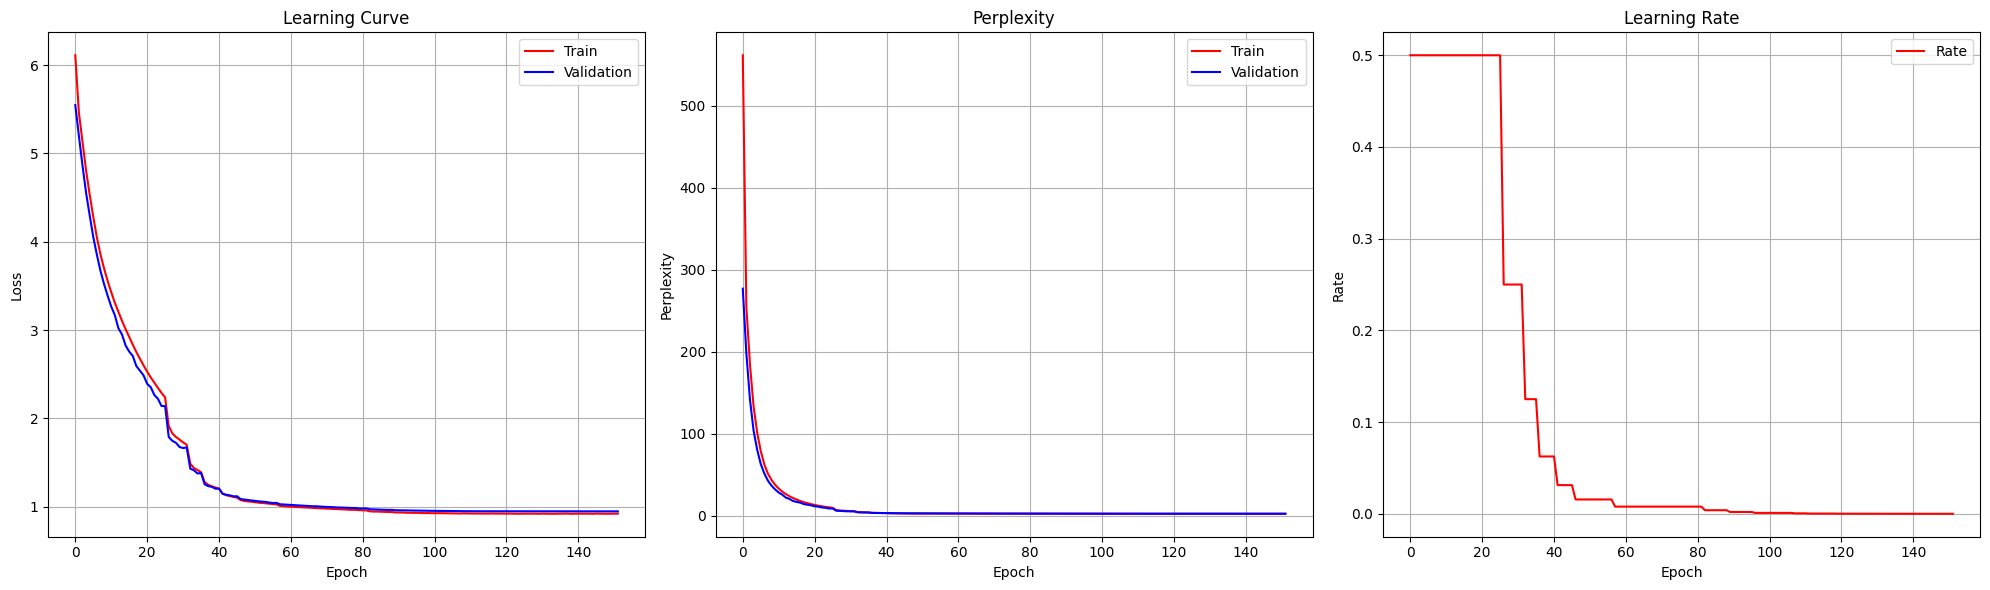

In [ ]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 0.9475 , Perplexity = 2.651
Test: Loss = 0.8427 , Perplexity = 2.355


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(9925, 256)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(256, 256, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(256, 256, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(256, 256, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=9925, bias=True)
)

In [22]:
num_trainable_params(model)

6.670533

In [25]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie loan breaks during the least two shape ratings the decision toward six times and in bulk of the new york district said he is not a first time for the house and chief executive officer of the new york area says they are to be the same time the company ' s sympathetic business that is in the new york stock market which is n ' t an increase in the market its stock market has been not more than a year in the stock market ' s stock market will be to be sold on the stock market in
